# Cell type compositional changes in response to morphogens

>scCODA models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions.(...) The model uses a Logit-normal spike-and-slab prior10 with a log-link function to estimate effects of binary (or continuous) covariates on cell-type proportions in a parsimonious fashion. (...) To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference. 
[(Büttner et al., 2021)](https://www.nature.com/articles/s41467-021-27150-6#Sec11)



In [1]:
# import all packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import colorcet as cc
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import scanpy as sc
import mudata as mu
import anndata as ad
import os
import gc
import pickle
import gzip

# import pertpy - it takes the gpu resources
import pertpy as pt
sccoda_model = pt.tl.Sccoda()

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.7.0!

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Global seed set to 0
/home/ubuntu/miniconda3/envs/pertpy/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/ubuntu/miniconda3/envs/pertpy/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# plots settings
%matplotlib inline
palette = sns.color_palette(cc.glasbey_light, n_colors=35)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(palette.as_hex())

# function that changes width of bars in barpltos
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# display all columns
pd.set_option('display.max_columns', None)

# set all relevant paths
path = '/storage/data/data/'
output = '/storage/data/2405_revision/scCODA_revision/'

## Load Data

In [3]:
adata = ad.read_h5ad(os.path.join(path, '230620_10_updated_manual_annotation.h5ad')) 

In [4]:
del adata.layers
gc.collect()

135

In [5]:
# add the information about SHH agonist in Wantabe protocol (it had merged organoids with and without SHH agonist)
adata.obs.loc[adata.obs['assay_differentiation']=='Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)', "SHH_agonist_raw"] = 1

In [6]:
for k in adata.obs_keys():
    if k.endswith("_raw"):
        adata.obs[k[:-4]] = adata.obs[k].replace({1: k[:-4], 0: "None"}).astype("category").cat.reorder_categories(["None", k[:-4]])

In [7]:
adata.obs["bio_sample"] = adata.obs["bio_sample"].astype(str)
# where bio_sample is unknown set it to the id
adata.obs.loc[adata.obs['bio_sample'] == 'unknown', "bio_sample"] = adata[adata.obs['bio_sample'] == 'unknown'].obs["id"]
adata.obs["bio_sample"] = adata.obs["bio_sample"].astype("category")

In [8]:
adata.obs["scCODA_region"] = pd.read_csv("/storage/data/2405_revision/new_metadata/metadata_240523.tsv.gz", sep="\t", index_col=0, low_memory=False)["annot_region_rev2"]

In [9]:
adata.obs.loc[adata.obs["scCODA_region"] == "Unspecific", "scCODA_region"] = adata.obs.loc[adata.obs["scCODA_region"] == "Unspecific", "manual_annot_ct"]

In [10]:
# remove PSC and neuroepithelium - displays only the early stage points
adata = adata[adata.obs['scCODA_region'] != 'PSC']
adata = adata[adata.obs['scCODA_region'] != 'neuroepithelium']

In [11]:
adata.obs['scCODA_region'].value_counts()

scCODA_region
Dorsal telencephalon        757626
Ventral telencephalon       158506
Medulla                     144802
Cerebellum                   99577
glioblast                    79506
CP                           77315
Thalamus                     73377
Pons                         54739
mesenchyme                   49273
astrocyte                    48956
Hypothalamus                 45229
Dorsal midbrain              44534
Ventral midbrain             22619
neural crest derivatives      9771
OPC                           8325
endothelial cell              2451
microglia                       96
Name: count, dtype: int64

* CP - choroid plexus; MC - mesenchyme; OPC - oligedendrite progenitor cells; EC - endothelial cell; PSC - pluripotent stem cells

## Cell composition analysis with scCODA 

### Prepare the data

In [50]:
morph_list = ['ECM', 'ROCK_inhibitor', 'BMP_activator', 'TGF_B_activator', 'TGF_B_inhibitor', 'BMP_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'EGF', 'FGF2', 'FGF8', 'SHH_agonist', 'RA', 'MEK_ERK_inhibitor', 'Notch_inhibitor']

In [51]:
sccoda_data_reg = sccoda_model.load(adata, 
                                    type="cell_level", 
                                    generate_sample_level=True, 
                                    cell_type_identifier="scCODA_region",  
                                    sample_identifier="bio_sample", 
                                    covariate_obs=morph_list
                                   )
print(sccoda_data_reg)

MuData object with n_obs × n_vars = 1677012 × 36859
  2 modalities
    rna:	1676702 x 36842
      obs:	'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease', 'ethnicity', 'gm', 'id', 'individual', 'organ', 'organism', 'sex', 'state_exact', 'sample_source', 'source_doi', 'suspension_type_original', 'tech_sample', 'treatment', 'assay_sc_original', 'cell_line_original', 'cell_type_original', 'development_stage_original', 'disease_original', 'ethnicity_original', 'organ_original', 'organism_original', 'sex_original', 'suspension_type', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_pca_unintegrated_1', 'leiden_pca_unintegrated_80', 'leiden_pca_rss_1', 'leiden_pca_rss_80', 'snapseed_pca_unintegrated_level_1', 'snapseed_pca_uninte

In [52]:
sccoda_data_reg.write_h5mu(os.path.join(output, 'scCODA_load_model_organoid_all_morphogens_bio-sample_region'))

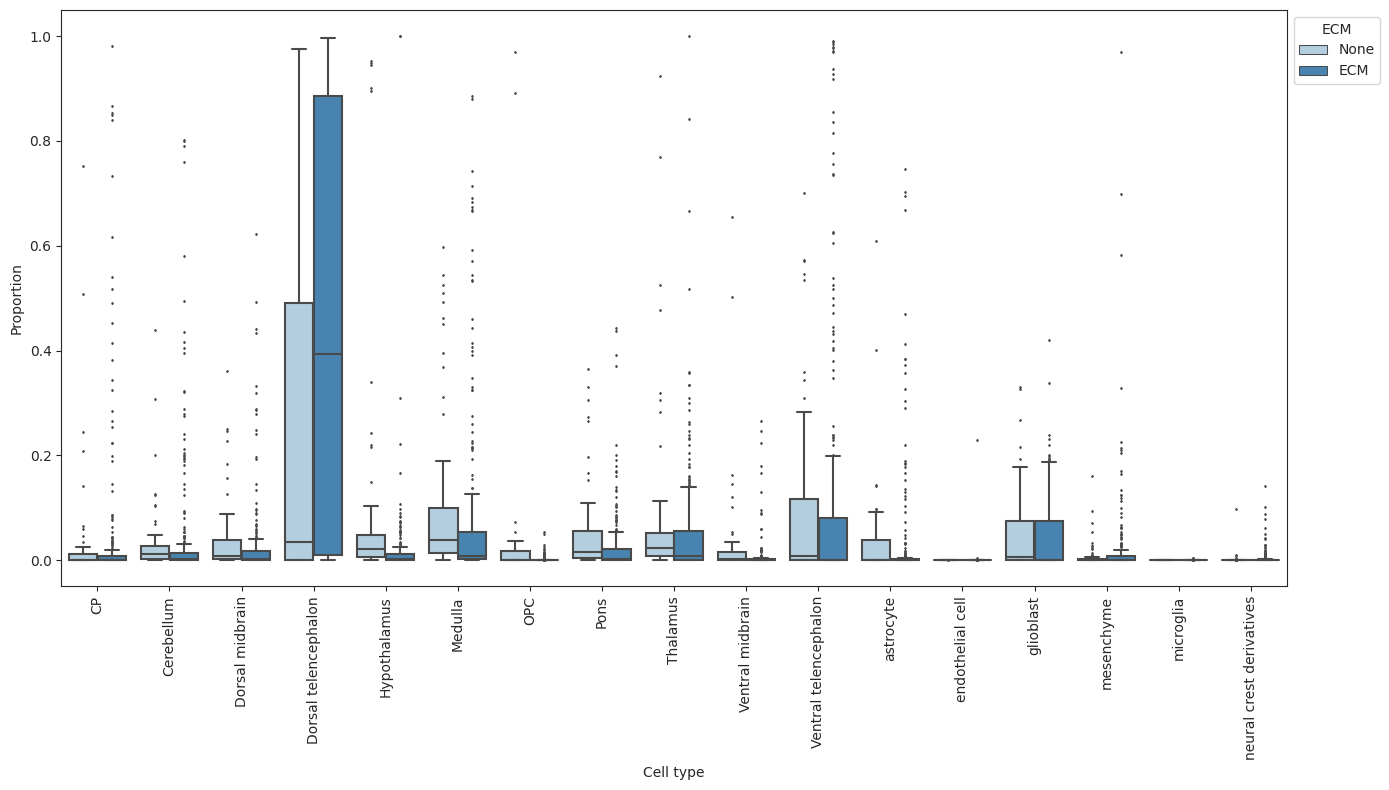

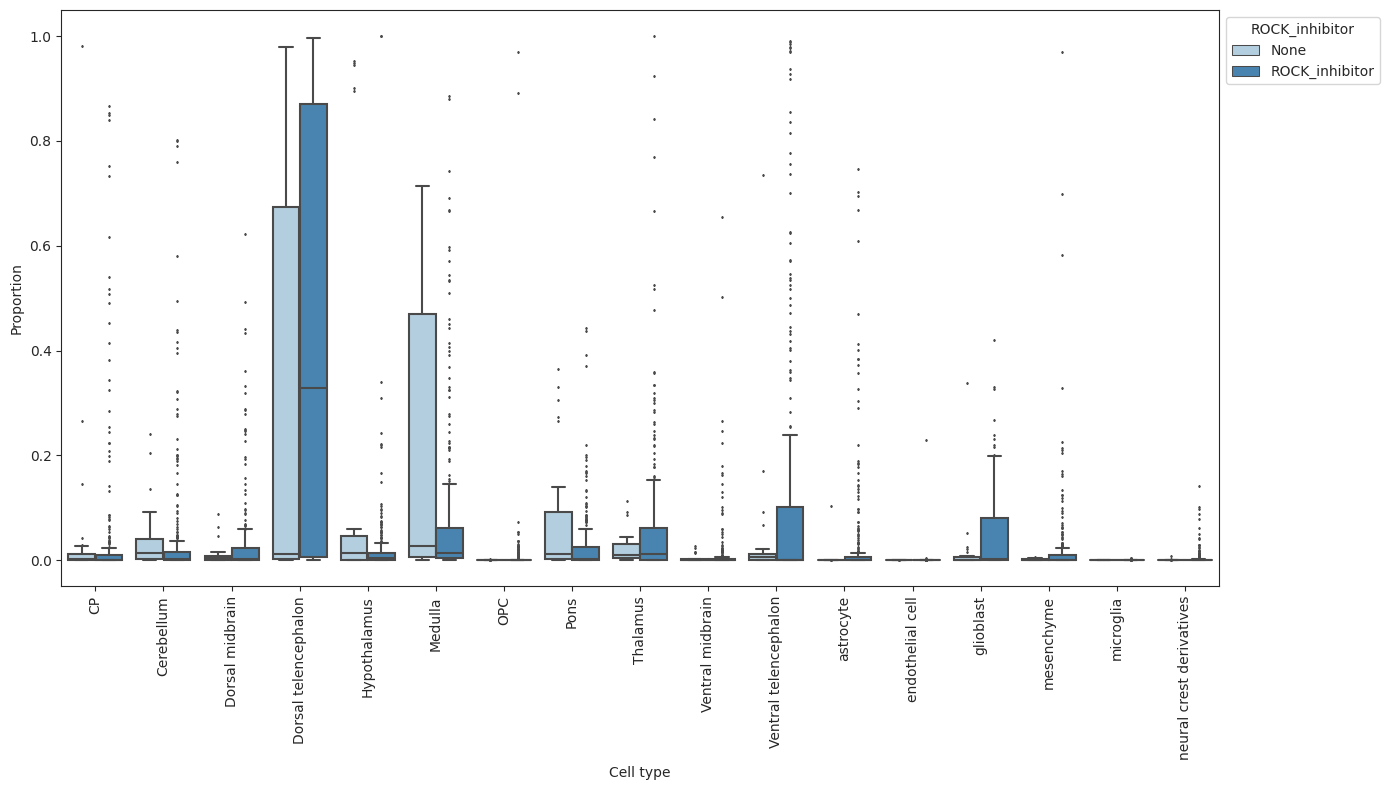

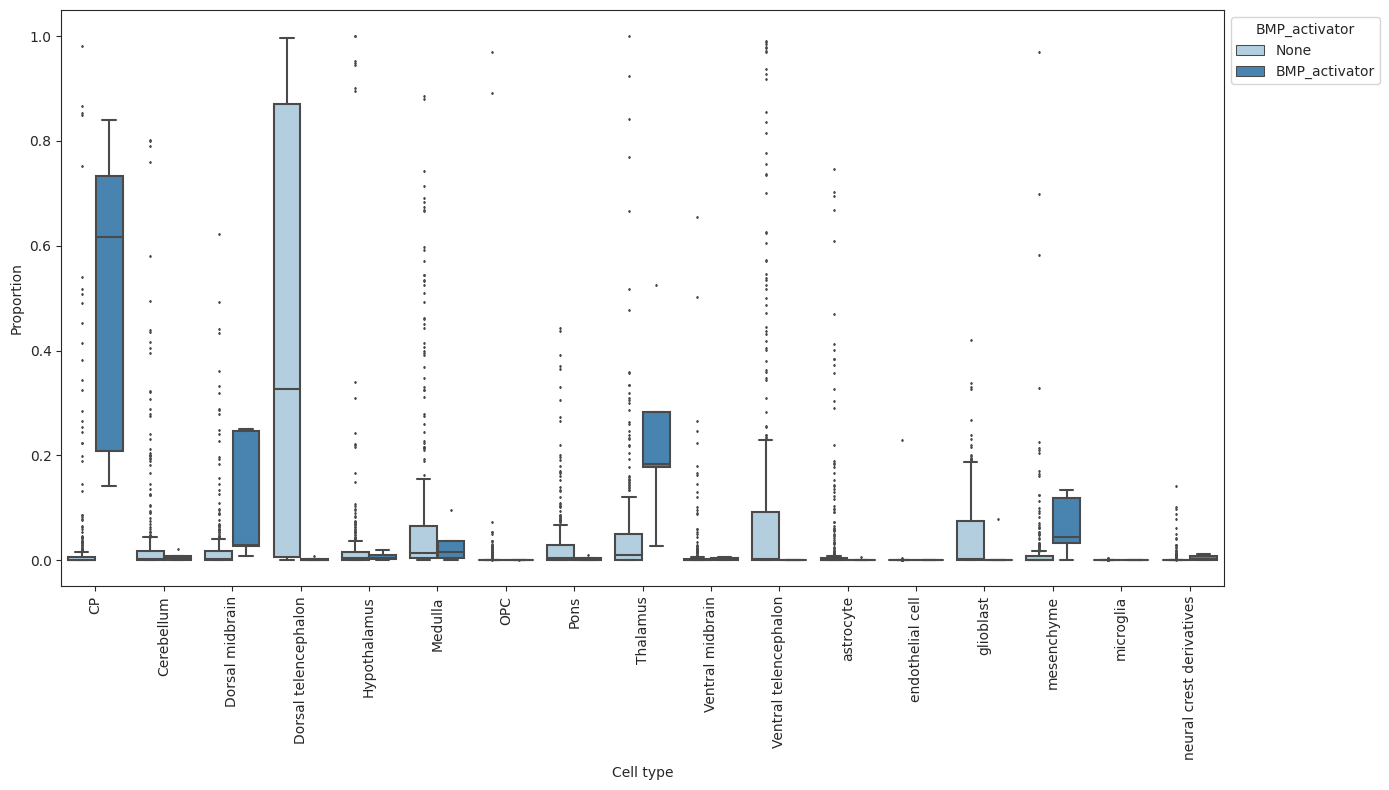

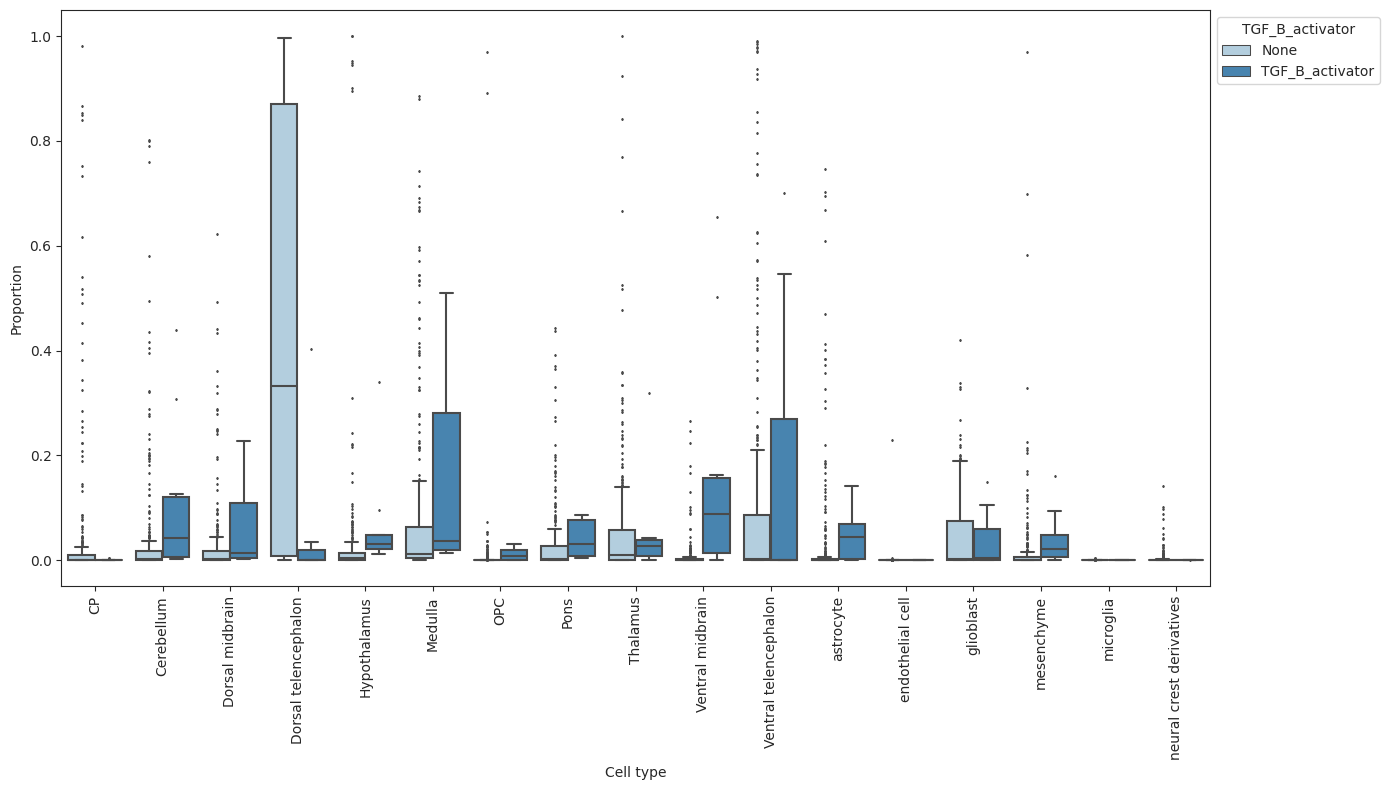

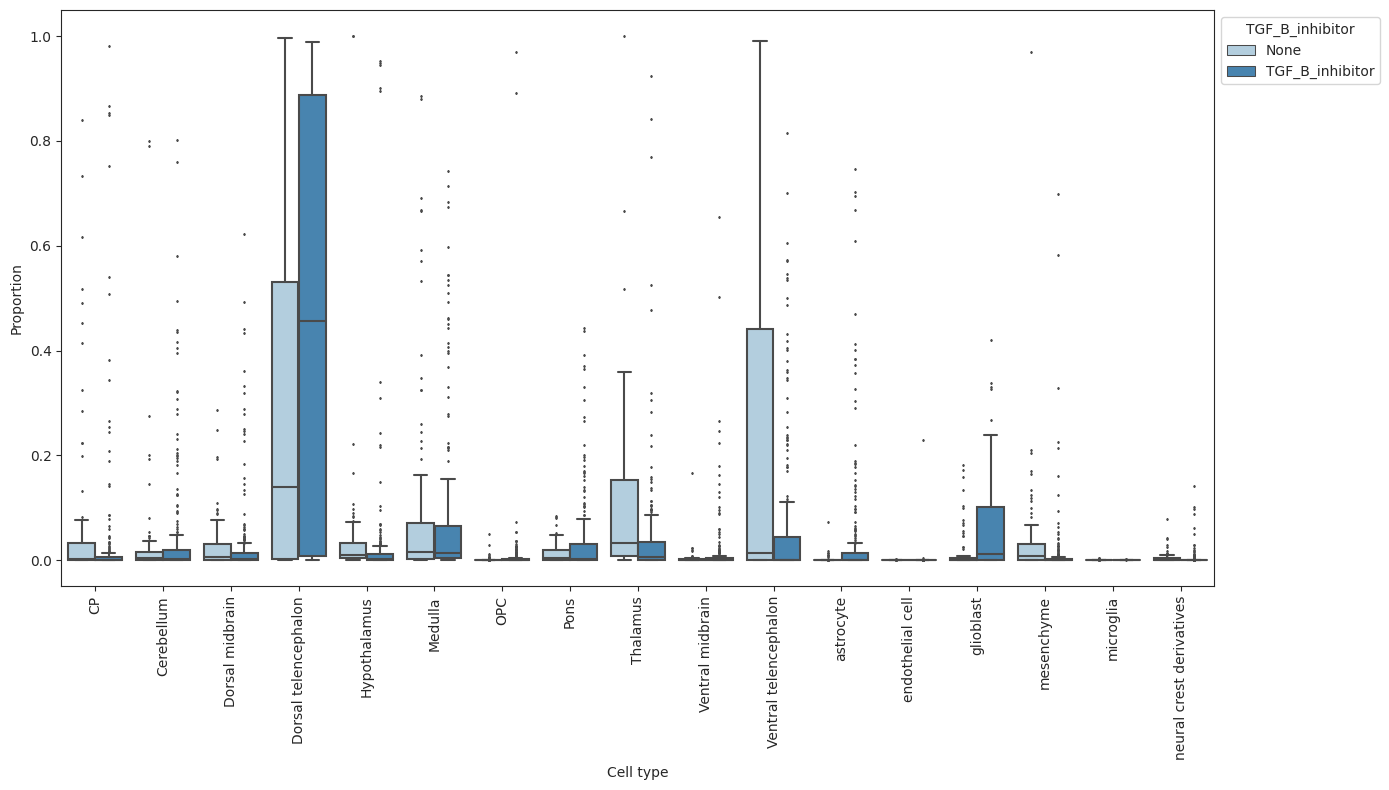

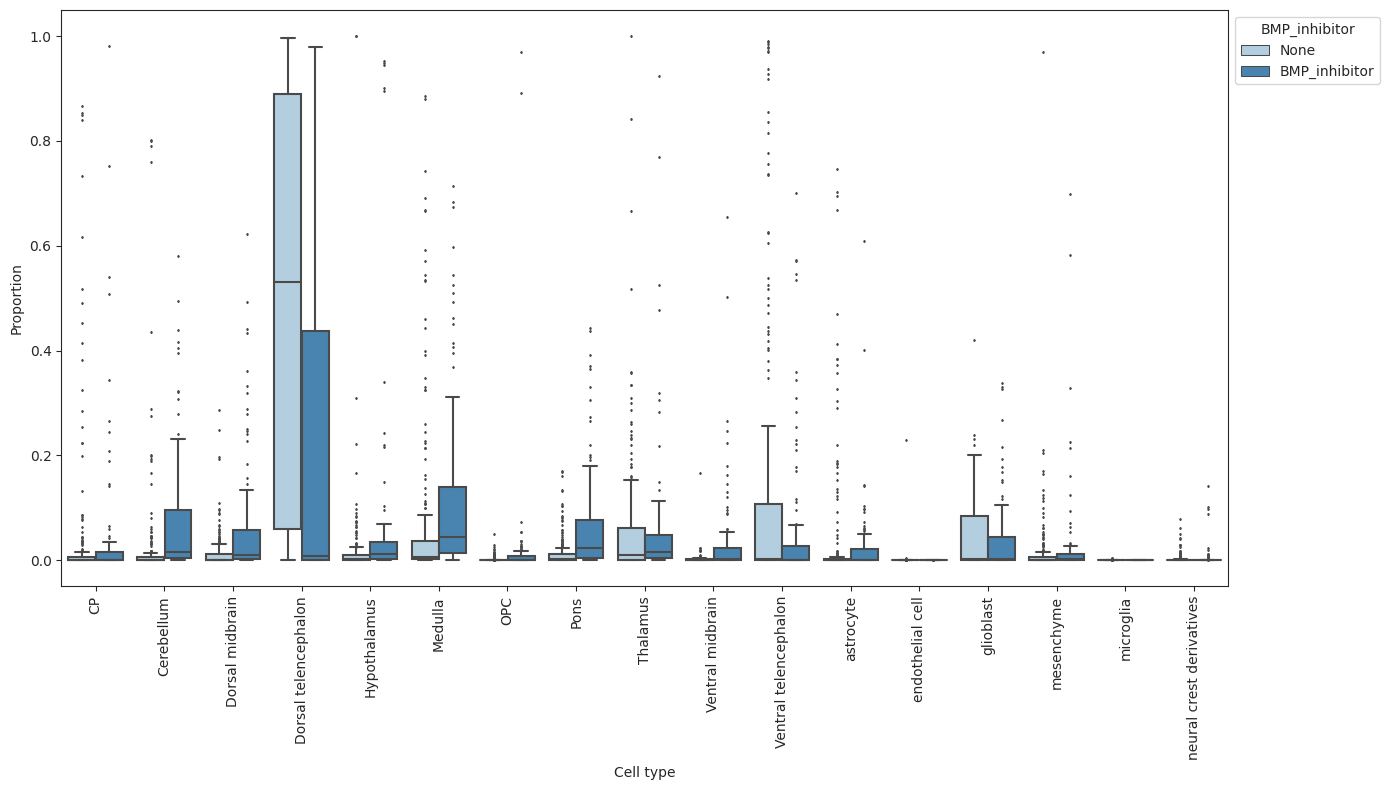

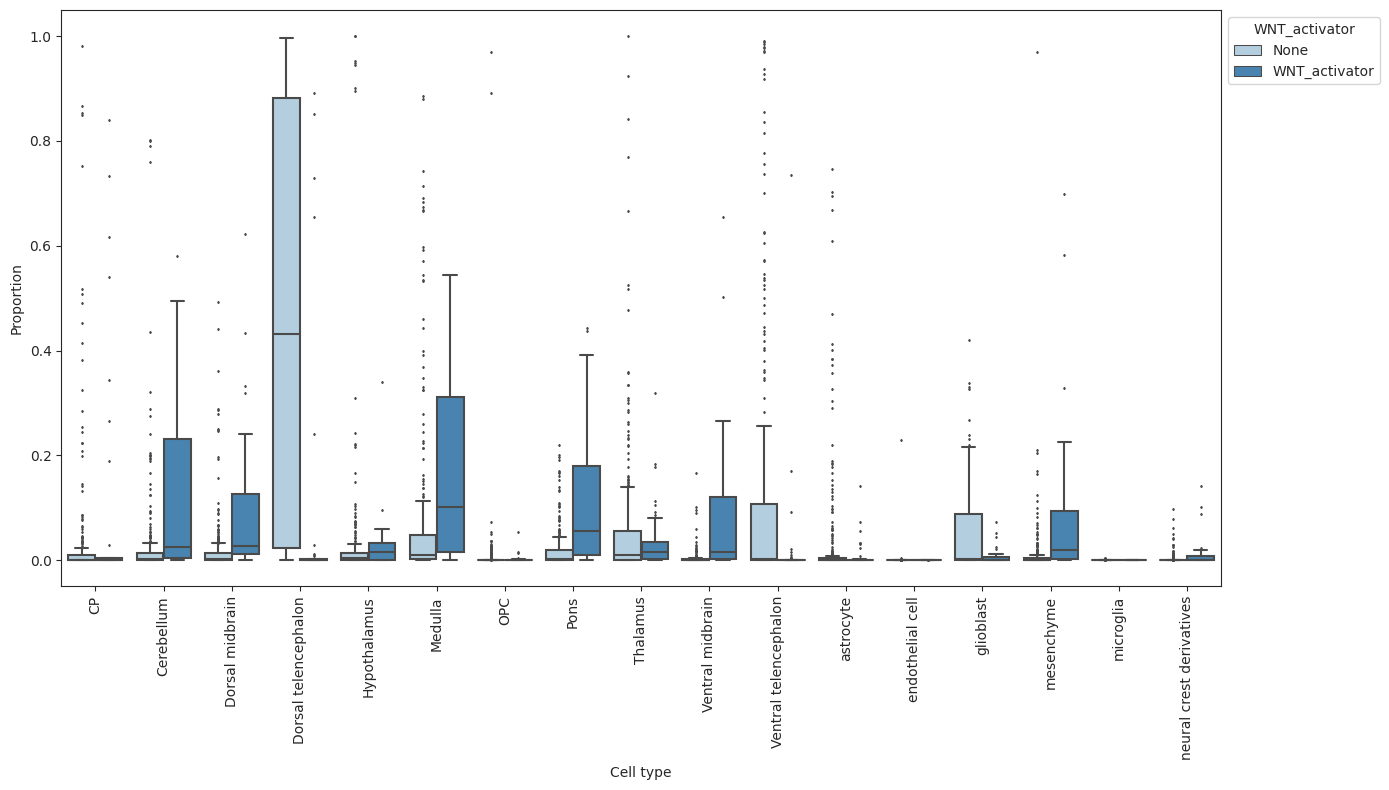

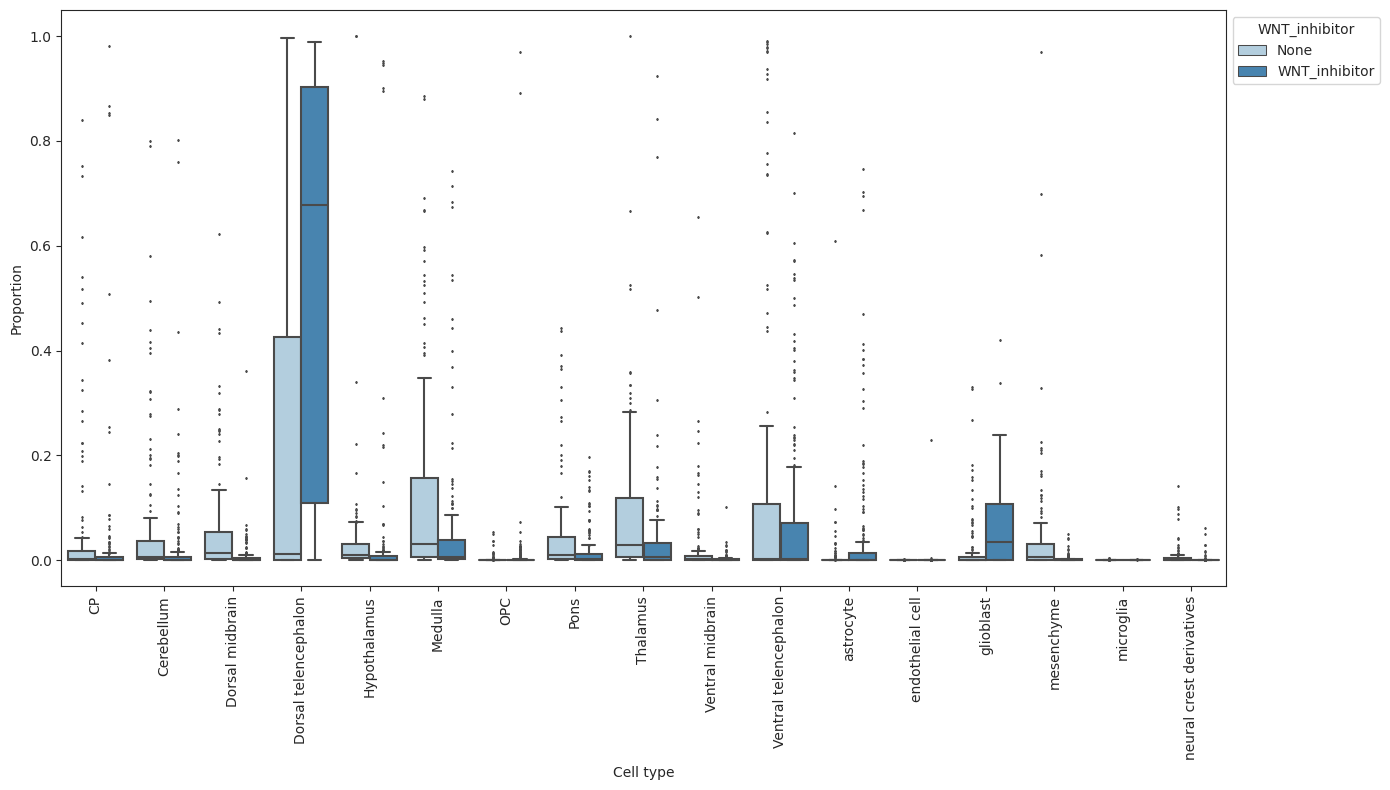

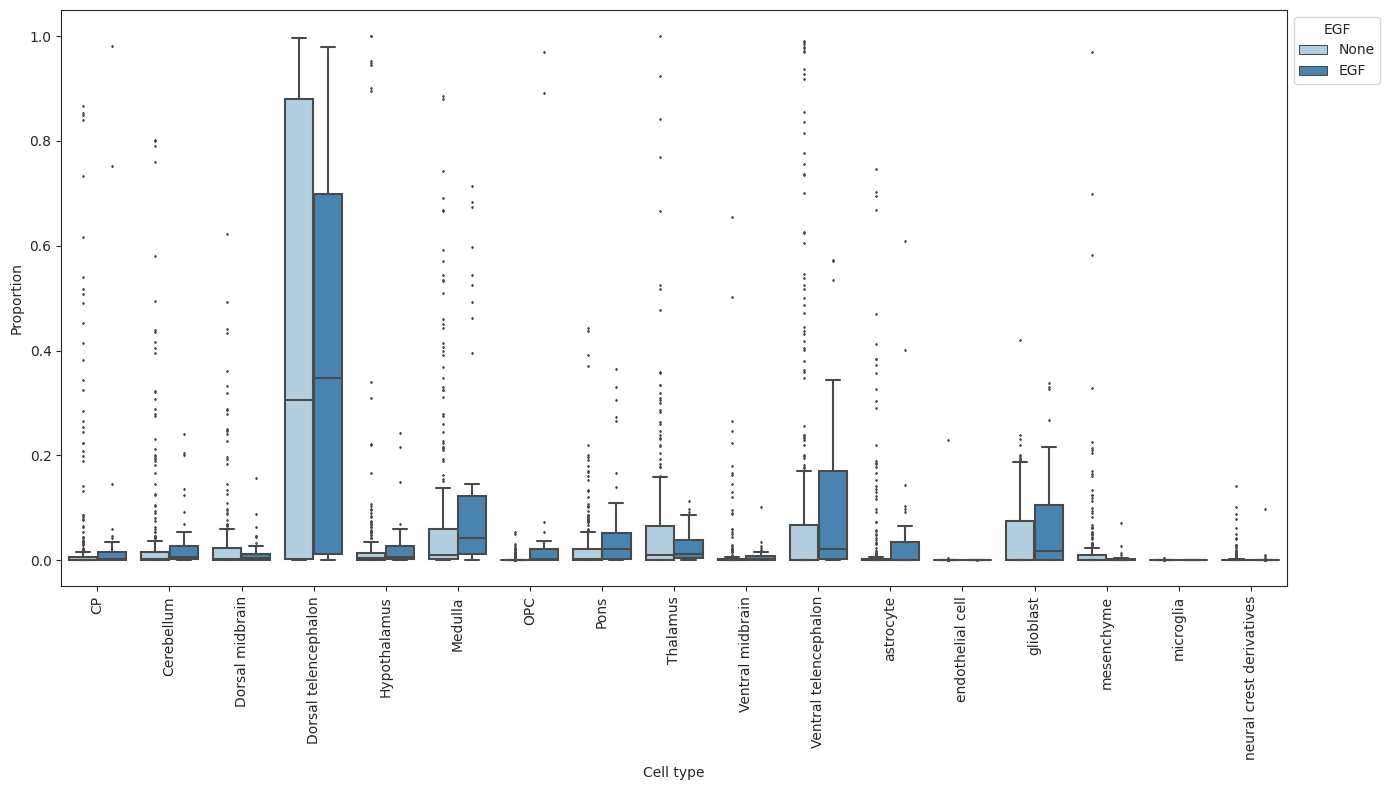

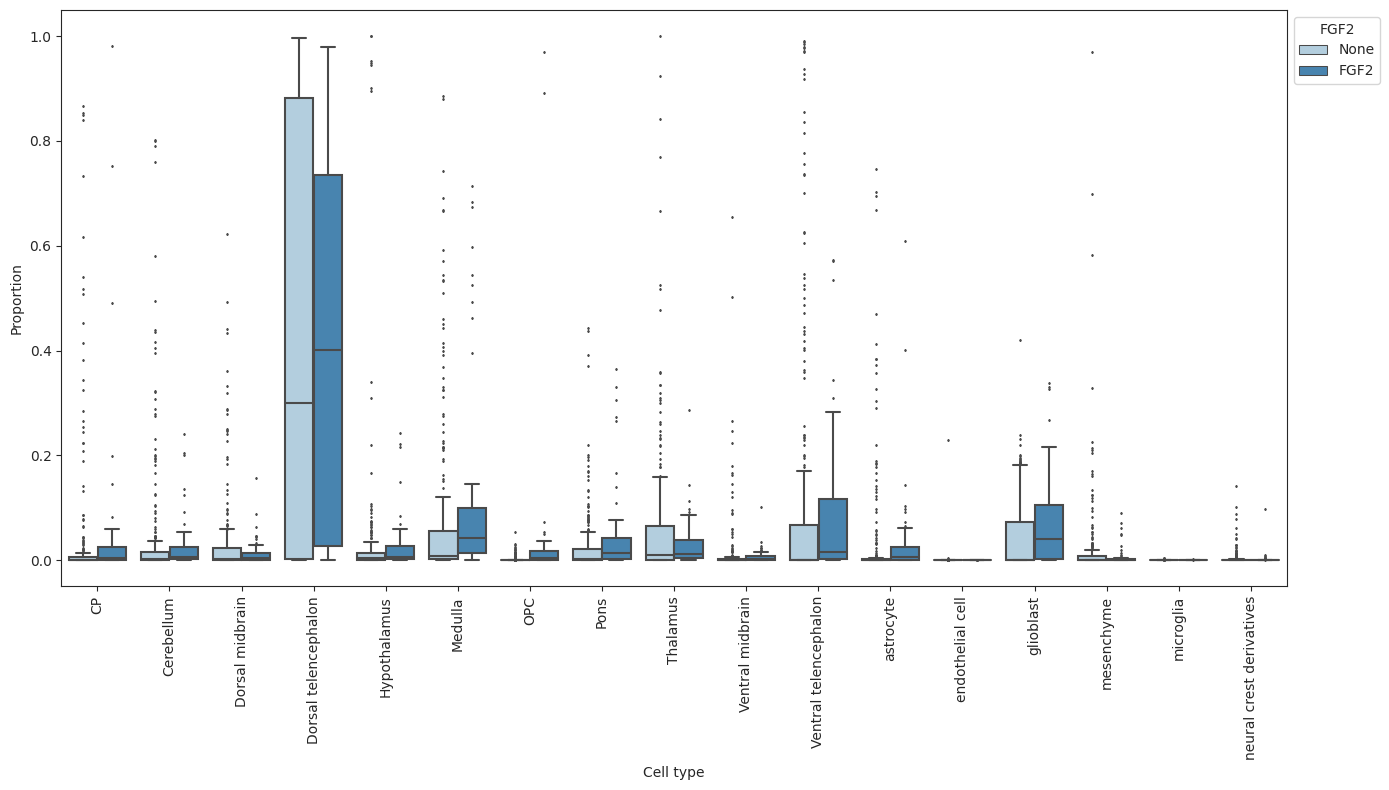

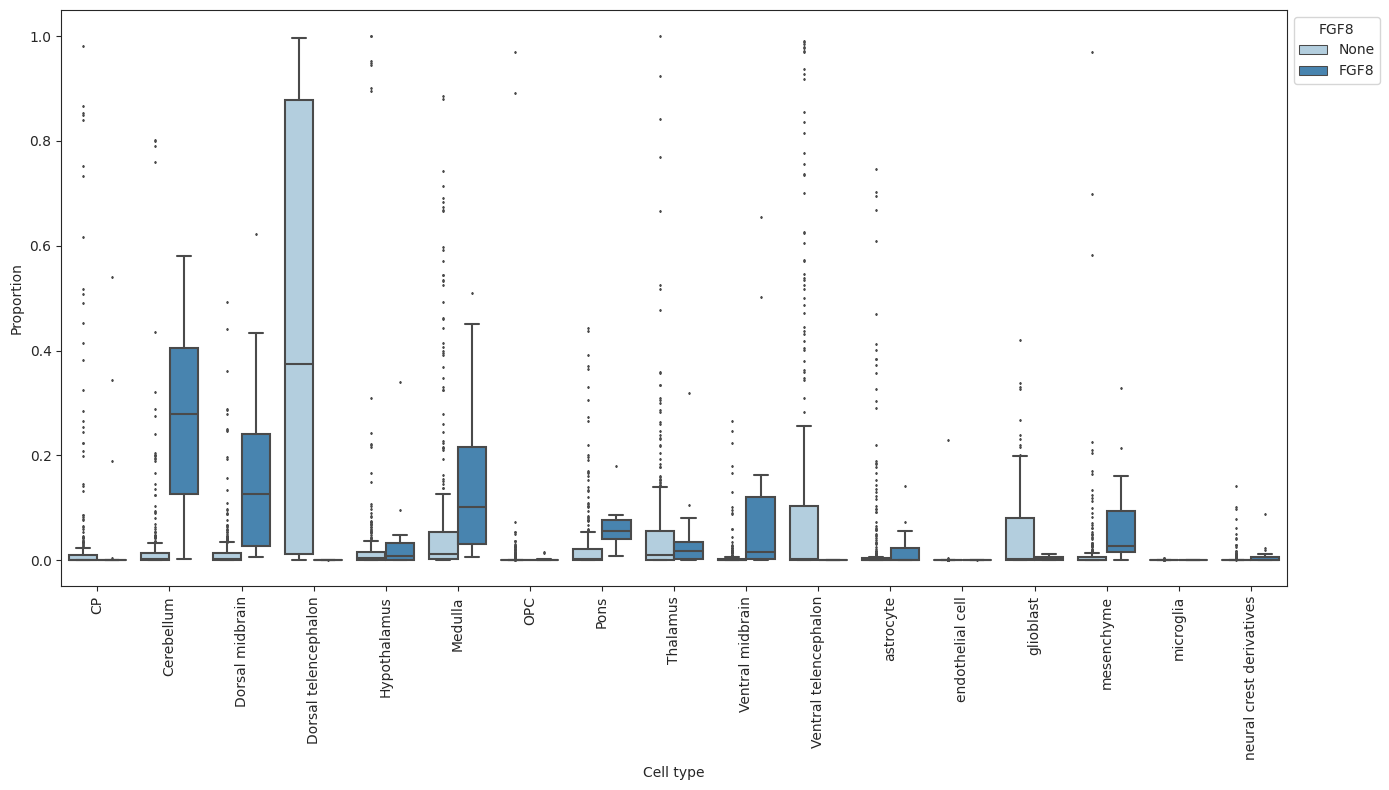

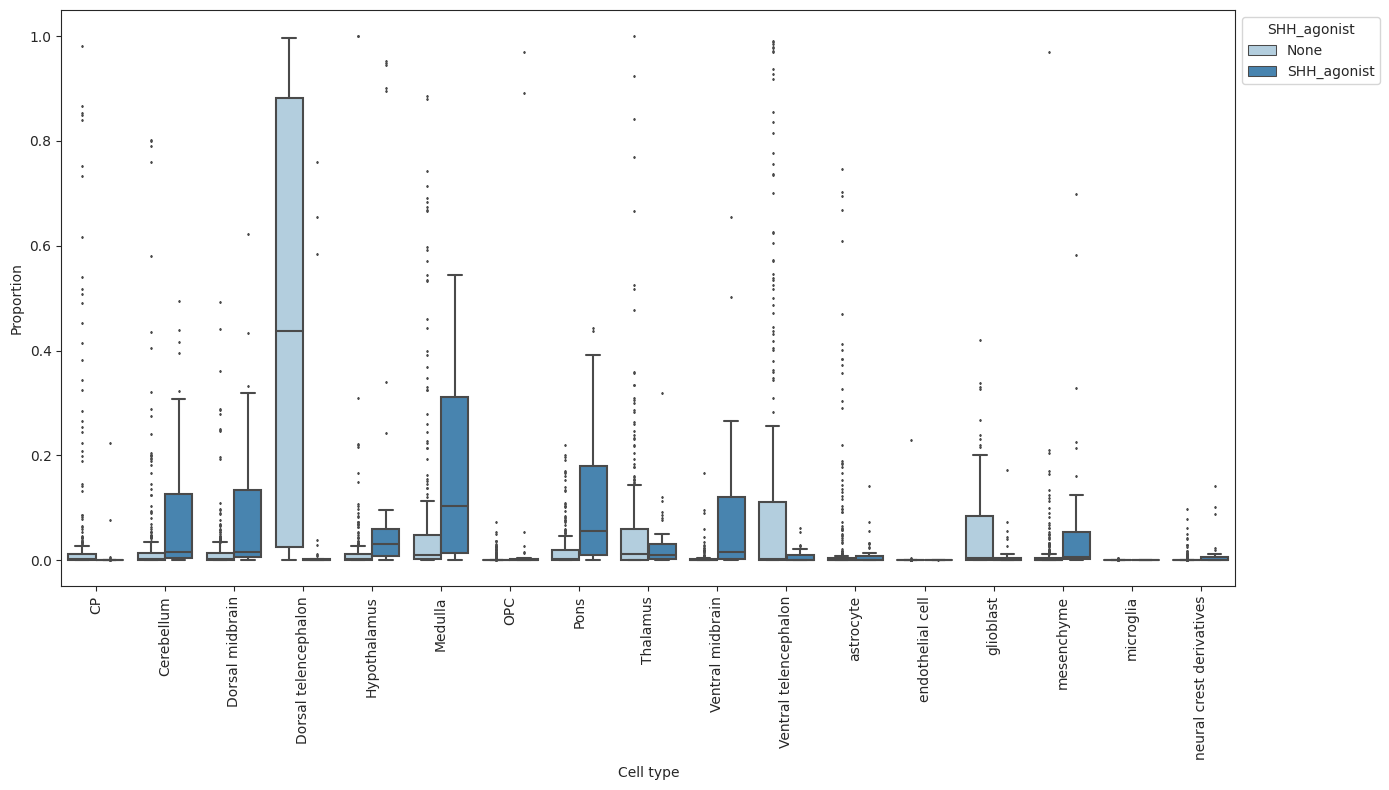

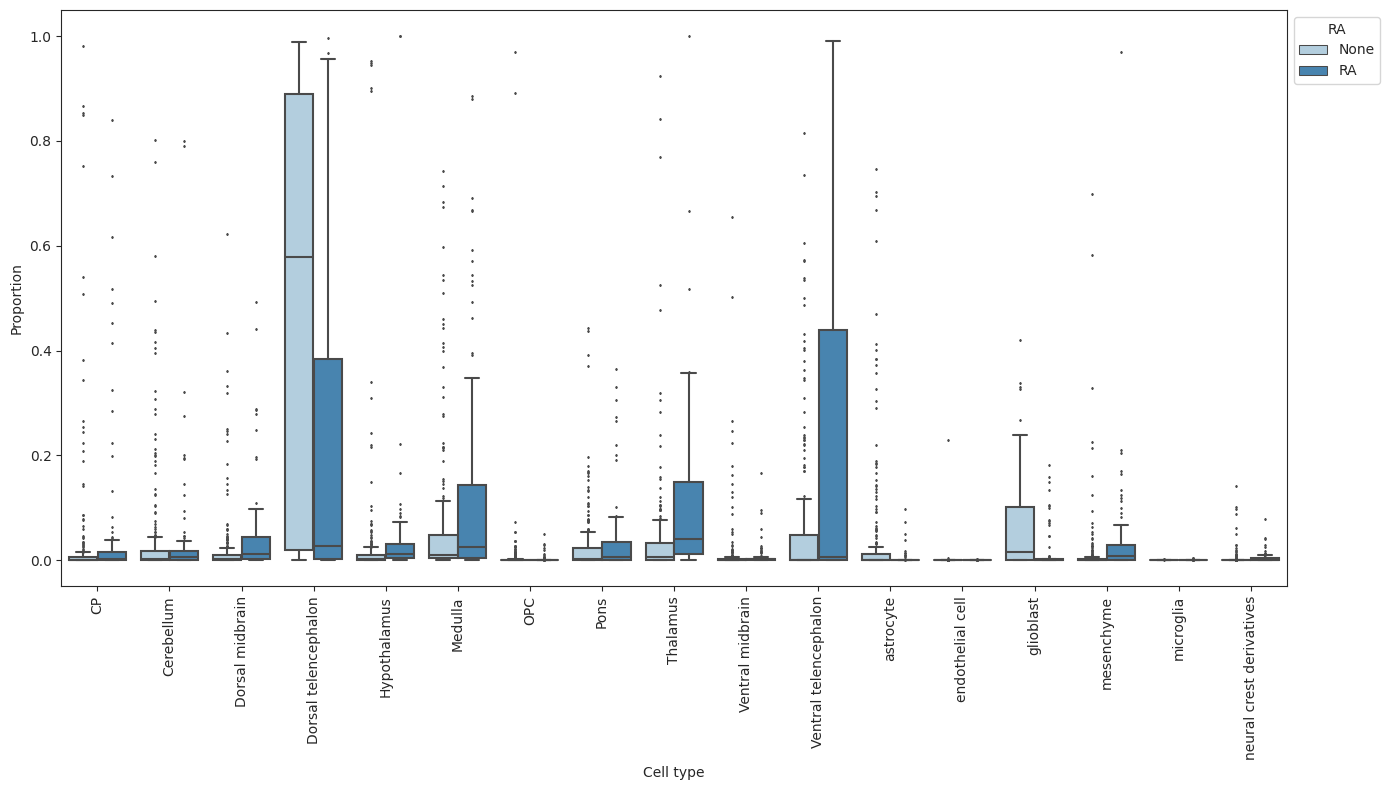

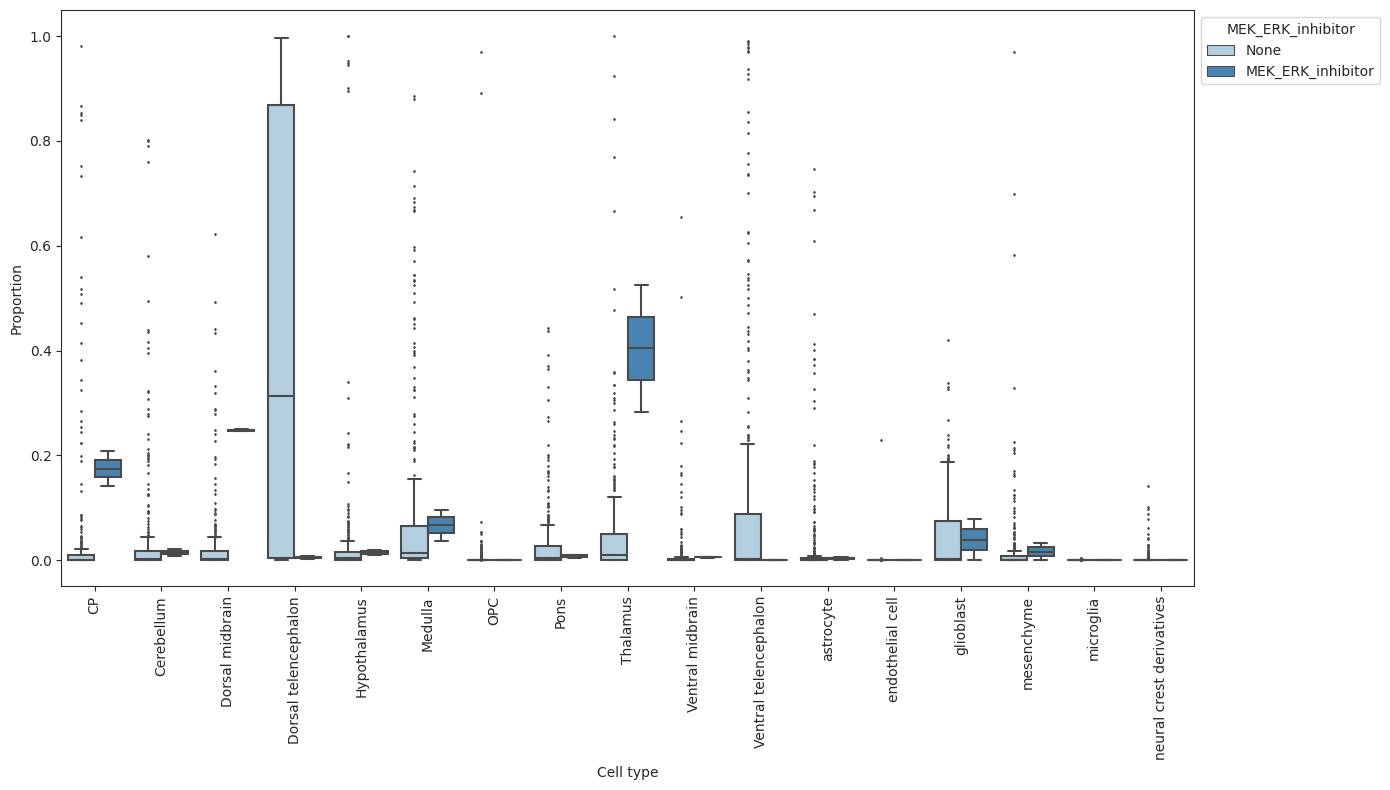

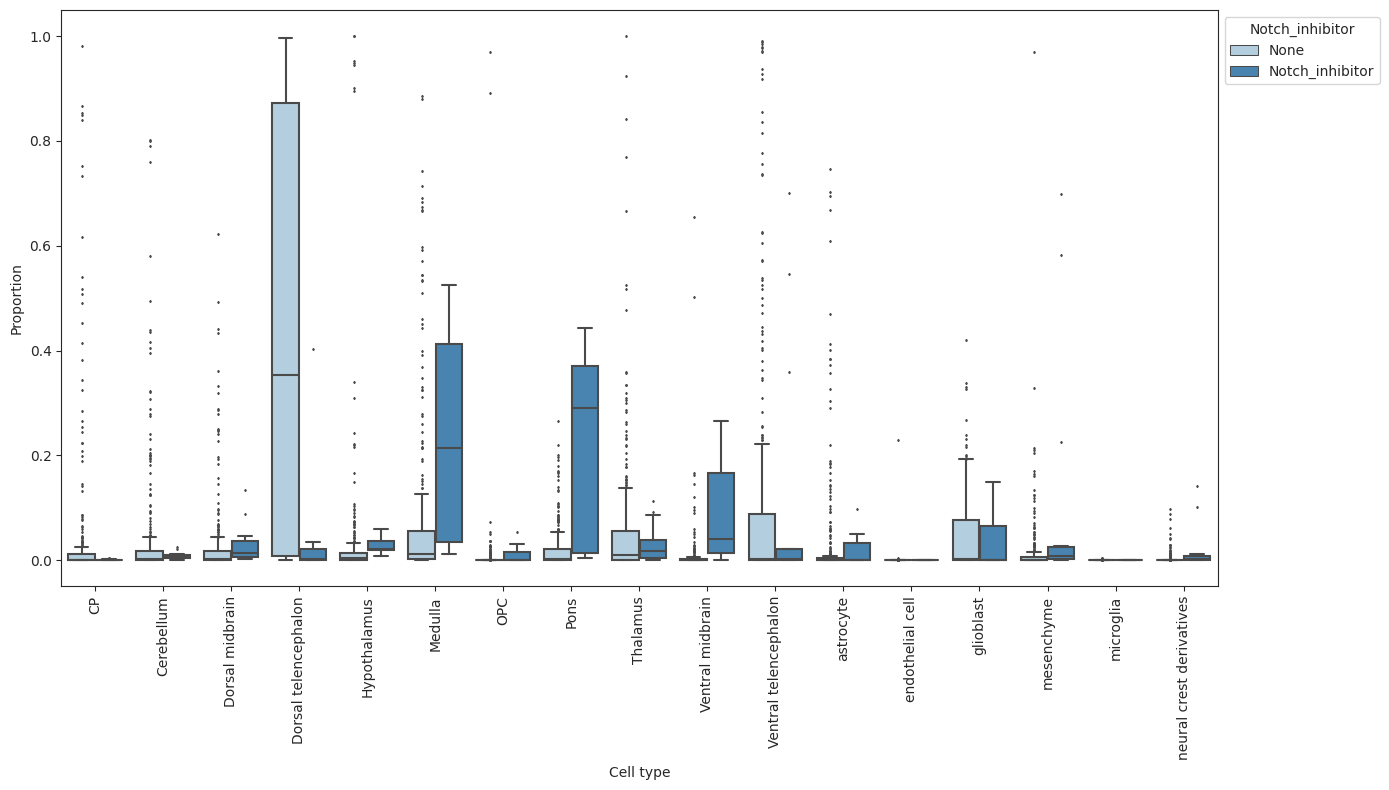

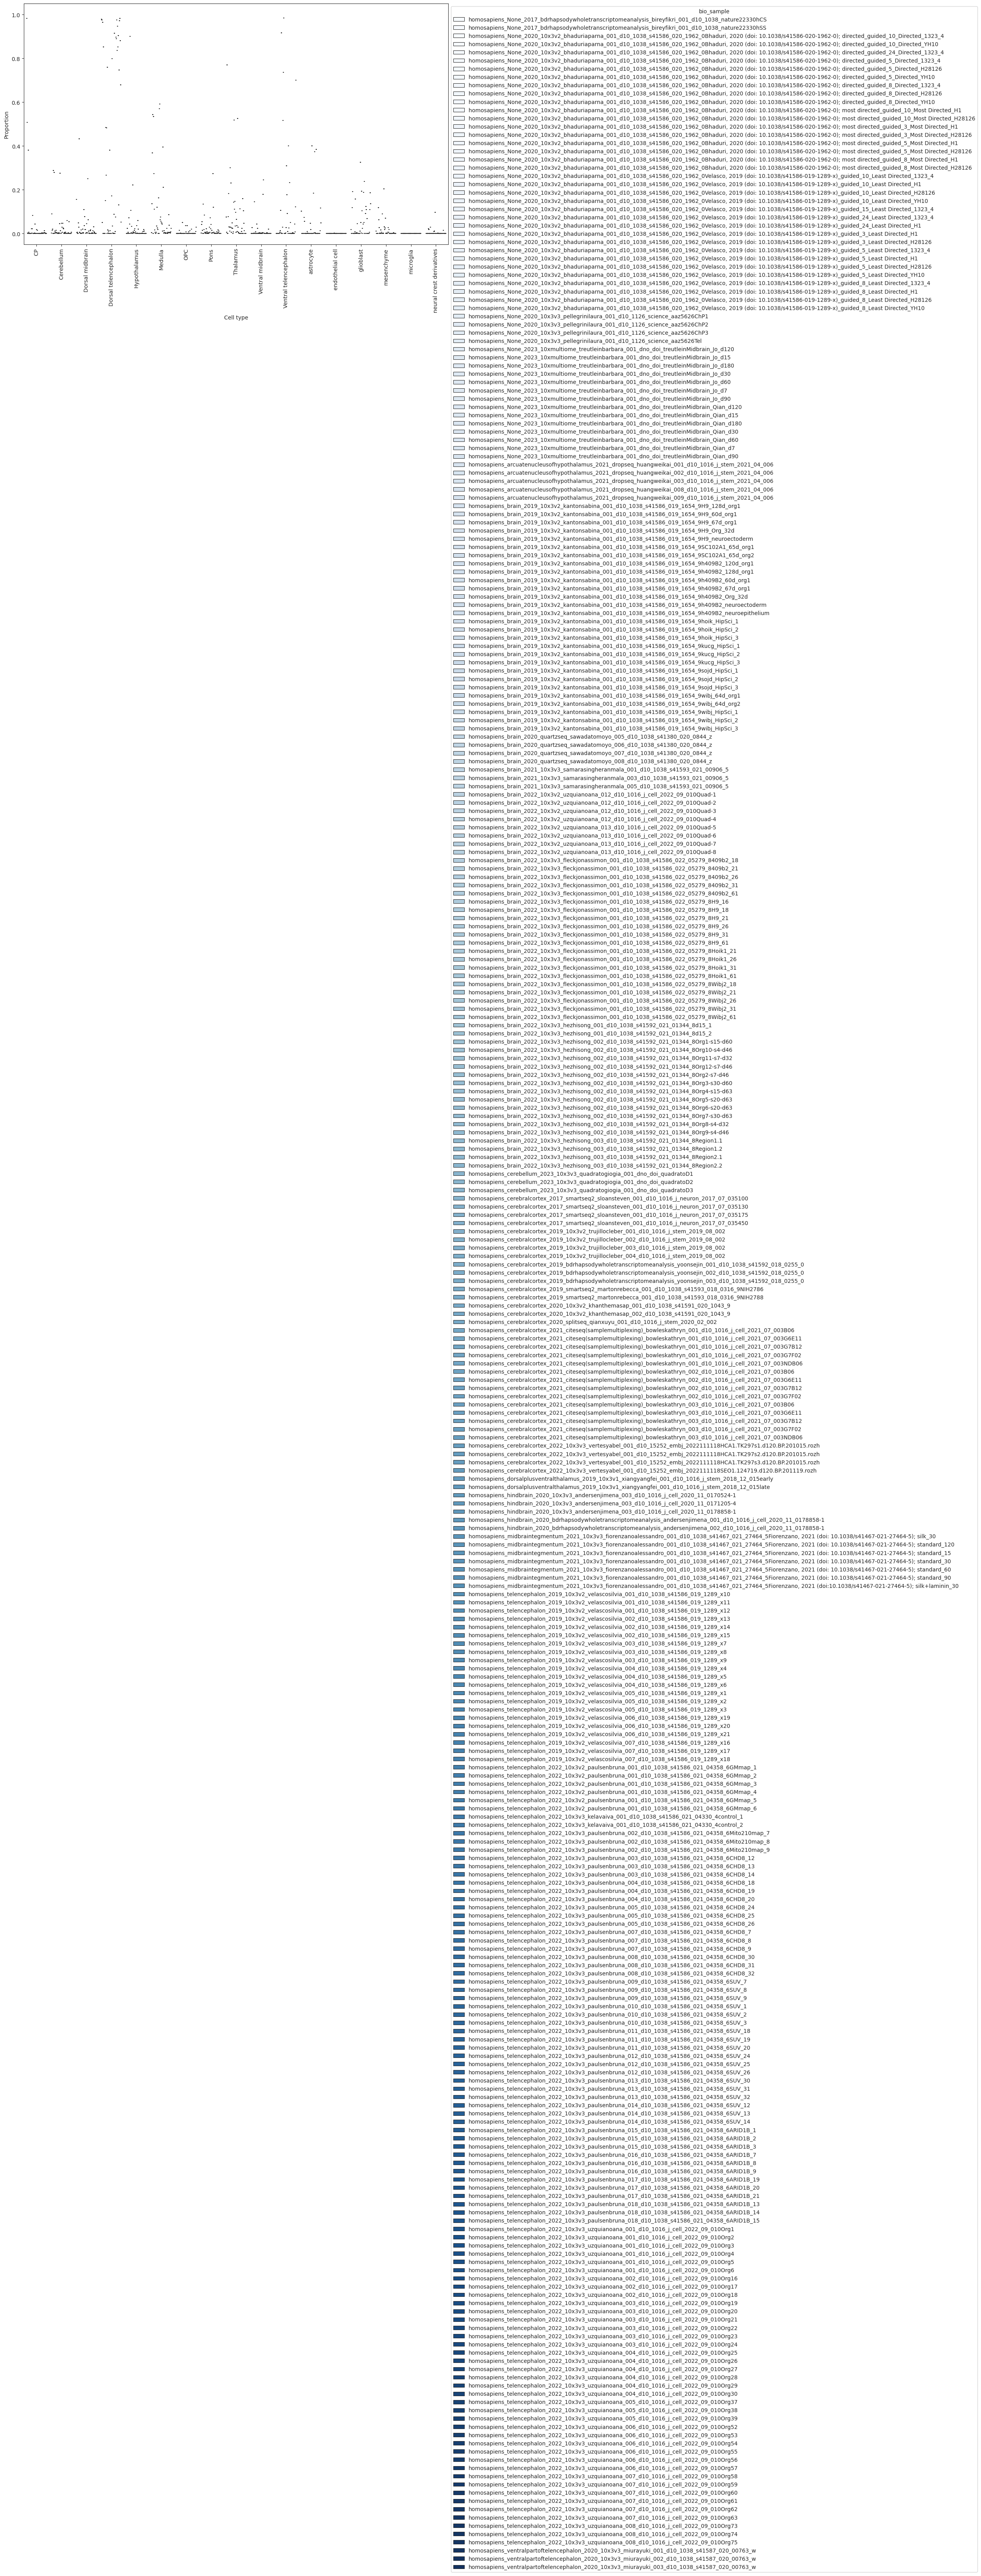

In [53]:
# plot boxplots
for i in morph_list:
    pt.pl.coda.boxplots(sccoda_data_reg, modality_key="coda", feature_name=i, figsize=[14,8])
    plt.savefig(fname = output + 'plots/' + i + '_scCODA_boxplot_region.pdf', format='pdf', bbox_inches='tight')

## Running the model

In [16]:
# Run scCODA with each cell type (region) as the reference
cell_types = sccoda_data_reg["coda"].var.index
morph_region = [i+"_"+j for i in morph_list for j in cell_types] # combining the info from the region and covariate (morphogen)
results_cycle = pd.DataFrame(index=morph_region, columns=["times_credible"]).fillna(0) 
cred_list = {}

In [33]:
for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    sccoda_data_all = sccoda_model.prepare(sccoda_data_reg, 
                                           modality_key="coda", 
                                           formula="ECM + ROCK_inhibitor + BMP_activator + TGF_B_activator + TGF_B_inhibitor + BMP_inhibitor + WNT_activator + WNT_inhibitor + EGF + FGF2 + FGF8 + SHH_agonist + RA + MEK_ERK_inhibitor + Notch_inhibitor", 
                                           reference_cell_type=ct)
    sccoda_model.run_nuts(sccoda_data_all, modality_key="coda")
    
    # Select credible effects
    cred_eff = sccoda_model.credible_effects(sccoda_data_all, modality_key="coda")
    cred_eff.index = cred_eff.index.get_level_values(0)+ "_"+ cred_eff.index.get_level_values(1) # combined cell type and morphogen
    cred_eff.index = cred_eff.index.str.replace('\[.*\]', '') # makes it nicer to read
    with open(os.path.join(output, 'cred_eff.pickle_'+ct), 'wb') as handle:
        pickle.dump(cred_eff, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")
    
    df_cred = sccoda_model.get_effect_df(sccoda_data_all, modality_key="coda")
    df_cred.reset_index(inplace=True)
    df_cred = df_cred[df_cred["Final Parameter"]!=0.0]
    # save the credible effects
    df_cred.to_csv(os.path.join(output, ct+'_scCODA_credible_change_bio_sample_final_region.csv')) 

    fig, ax = plt.subplots(figsize=(13, 6), constrained_layout=True)
    sns.barplot(data=df_cred, 
                x="Cell Type", 
                y="log2-fold change", 
                hue="Covariate",
               palette = palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), ncol=1)
    change_width(ax, .25)
    plt.savefig(fname=output+'scCODA_credible_effect_morphogens_ref_'+ct+'_region_bio_sample_LFC.pdf',format='pdf')
    labels = ax.get_xticklabels()

Reference: CP


Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|█| 11000/11000 [2:26:30<00:00,  1.25it/s, 10


Reference: Cerebellum


sample: 100%|█| 11000/11000 [2:28:16<00:00,  1.24it/s, 10


Reference: Dorsal midbrain


sample: 100%|█| 11000/11000 [2:29:17<00:00,  1.23it/s, 10


Reference: Dorsal telencephalon


sample:  74%|▋| 8128/11000 [1:48:39<39:53,  1.20it/s, 102IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sample:  83%|▊| 9179/11000 [2:01:13<20:12,  1.50it/s, 298IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sample:  88%|▉| 9722/11000 [2:09:27<17:34,  1.21it/s, 102IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopu

Reference: Ventral midbrain


sample: 100%|█| 11000/11000 [2:30:24<00:00,  1.22it/s, 10


Reference: Ventral telencephalon


sample: 100%|█| 11000/11000 [2:30:28<00:00,  1.22it/s, 10


Reference: astrocyte


sample: 100%|█| 11000/11000 [2:31:42<00:00,  1.21it/s, 10


Reference: endothelial cell


sample: 100%|█| 11000/11000 [2:30:14<00:00,  1.22it/s, 10


Reference: glioblast


sample:  66%|▋| 7299/11000 [1:36:45<50:32,  1.22it/s, 102IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sample:  72%|▋| 7949/11000 [1:45:19<41:26,  1.23it/s, 102IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sample:  73%|▋| 8026/11000 [1:45:09<39:41,  1.25it/s, 102IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopu

## Preparing the output data

In [55]:
morph_list = ['ECM', 'ROCK_inhibitor', 'BMP_activator', 'TGF_B_activator', 'TGF_B_inhibitor', 'BMP_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'EGF', 'FGF2', 'FGF8', 'SHH_agonist', 'RA', 'MEK_ERK_inhibitor', 'Notch_inhibitor']
cred_list = {}
morph_region = []
for i in range(len(cell_types)):
    for j in range(len(morph_list)):
        temp = cell_types[i]+'_'+morph_list[j]
        morph_region.append(temp)
results_cycle = pd.DataFrame(index=morph_region)
res_LFC=pd.DataFrame(index=morph_region)

In [56]:
for ct in cell_types:
    df_cred=pd.read_csv(os.path.join(output, ct+'_scCODA_credible_change_bio_sample_final_region.csv'))
    df_cred = df_cred.rename(columns={"Cell Type": 'Region'})
    df_cred['Morphogens'] = df_cred['Covariate'].str.split(".").str[1]
    df_cred["Morphogens"] = df_cred["Morphogens"].astype('category')
    df_cred["Region_Morphogen"]=df_cred['Region']+'_'+df_cred['Morphogens'].astype('str')
    df_cred['Reference:'+ct]=1
    
    results=df_cred[['Region_Morphogen','Reference:'+ct]]
    results.index = results['Region_Morphogen']
    del results['Region_Morphogen']
    results_cycle = results_cycle.add(results, fill_value=0)
    
    df_cred['Reference:'+ct+'_LFC']=df_cred['log2-fold change']
    res=df_cred[['Region_Morphogen','Reference:'+ct+'_LFC']]
    res.index = res['Region_Morphogen']
    del res['Region_Morphogen']
    res_LFC = res_LFC.add(res, fill_value=0)
    
    cred_list.update({ct:df_cred})

In [57]:
results_cycle.fillna(0, inplace=True)

In [58]:
results_sum = pd.DataFrame(results_cycle.sum(axis=1))
results_sum = results_sum.rename(columns={0: 'times_credible'})
results_sum["pct_credible"] = results_sum["times_credible"]/len(cell_types)
results_sum["is_credible"] = results_sum["pct_credible"] > 0.5

In [59]:
res_credible = results_sum[results_sum['is_credible']==True]
res_credible.shape

(45, 3)

In [60]:
assert np.all(res_LFC.index == results_sum.index)
res_LFC
res_LFC_T = res_LFC[results_sum["is_credible"]==True]

df = pd.DataFrame(res_LFC.mean(axis=1))
df.loc[results_sum["is_credible"]==False, 0] = 0

In [74]:
# make a multiindex 
arrays = [[item[0] for item in res_LFC.index.str.split('_')],
         ["_".join(item[1:]) for item in res_LFC.index.str.split('_')]]
index = pd.MultiIndex.from_arrays(arrays, names=('Region', 'Morphogen'))
df.index = index

In [75]:
df_res = df.unstack(level=1)
df_res.columns = df_res.columns.droplevel()
df_res

Morphogen                 BMP_activator  BMP_inhibitor       ECM       EGF  \
Region                                                                       
CP                             4.962331       0.000000  0.000000  0.000000   
Cerebellum                     0.000000       1.654790  0.000000  0.000000   
Dorsal midbrain                0.022670       1.570481  0.000000  0.000000   
Dorsal telencephalon           0.000000      -2.450605 -0.036232  0.000000   
Hypothalamus                   0.000000       0.000000 -1.026845 -1.436559   
Medulla                        0.000000       0.000000  0.000000  0.000000   
OPC                            0.000000       0.000000  0.000000  0.000000   
Pons                           0.000000       0.000000  0.000000  0.000000   
Thalamus                       1.250511       0.000000  0.237304  0.000000   
Ventral midbrain               0.000000       0.000000  0.000000  0.000000   
Ventral telencephalon          0.000000       0.000000  0.082469  1.297829   
astrocyte                      0.000000       0.000000  0.000000  0.000000   
endothelial cell               0.000000       0.000000  0.000000  0.000000   
glioblast                      0.000000       0.000000  0.000000  0.000000   
mesenchyme                     1.237408       0.000000  0.000000  0.000000   
microglia                      0.000000       0.000000  0.000000  0.000000   
neural crest derivatives       0.000000       0.000000  0.000000  0.000000   

Morphogen                     FGF2      FGF8  MEK_ERK_inhibitor  \
Region                                                            
CP                        0.000000  0.000000          -2.679240   
Cerebellum                0.000000  2.797837           0.000000   
Dorsal midbrain           0.000000  1.526026           2.175196   
Dorsal telencephalon      0.778758  0.000000           0.000000   
Hypothalamus              0.000000  0.000000           0.000000   
Medulla                   0.000000  0.000000           2.258037   
OPC                       0.000000  0.000000           0.000000   
Pons                      0.000000  0.000000           0.000000   
Thalamus                  0.000000  0.000000           0.000000   
Ventral midbrain          0.000000  0.000000           0.000000   
Ventral telencephalon     0.000000  0.000000           0.000000   
astrocyte                -0.175638  0.000000           0.000000   
endothelial cell          0.000000  0.000000           0.000000   
glioblast                 0.644406  0.000000           0.000000   
mesenchyme                0.000000  0.000000          -2.261720   
microglia                 0.000000  0.000000           0.000000   
neural crest derivatives  0.000000  0.000000           0.000000   

Morphogen                 Notch_inhibitor        RA  ROCK_inhibitor  \
Region                                                                
CP                                    0.0  0.000000        0.000000   
Cerebellum                            0.0  0.847857        0.000000   
Dorsal midbrain                       0.0  1.460215        0.000000   
Dorsal telencephalon                  0.0 -1.569148        0.000000   
Hypothalamus                          0.0  0.000000       -1.682909   
Medulla                               0.0  1.972057        0.000000   
OPC                                   0.0  0.000000        0.000000   
Pons                                  0.0  2.000238        0.000000   
Thalamus                              0.0  1.356184        0.000000   
Ventral midbrain                      0.0  0.000000        0.000000   
Ventral telencephalon                 0.0  0.000000        0.000000   
astrocyte                             0.0  0.000000        0.000000   
endothelial cell                      0.0  0.000000        0.000000   
glioblast                             0.0  0.000000        1.283538   
mesenchyme                            0.0  0.000000        0.000000   
microglia                           

In [76]:
df_freq = pd.DataFrame(results_cycle.sum(axis=1))
arrays = [[item[0] for item in df_freq.index.str.split('_')],
         ["_".join(item[1:]) for item in df_freq.index.str.split('_')]]
index = pd.MultiIndex.from_arrays(arrays, names=('Region', 'Morphogen'))
df_freq.index = index
df_freq = df_freq.unstack(level=1)
df_freq.columns = df_freq.columns.droplevel()
df_freq

Morphogen                 BMP_activator  BMP_inhibitor   ECM   EGF  FGF2  \
Region                                                                     
CP                                 16.0            0.0   0.0   0.0   0.0   
Cerebellum                          0.0           16.0   0.0   0.0   0.0   
Dorsal midbrain                    13.0           16.0   0.0   0.0   0.0   
Dorsal telencephalon                6.0           16.0  16.0   0.0  16.0   
Hypothalamus                        0.0            0.0  16.0  16.0   0.0   
Medulla                             0.0            0.0   1.0   0.0   2.0   
OPC                                 0.0            0.0   0.0   0.0   0.0   
Pons                                1.0            0.0   0.0   0.0   0.0   
Thalamus                           15.0            1.0  12.0   0.0   0.0   
Ventral midbrain                    0.0            0.0   0.0   0.0   0.0   
Ventral telencephalon               1.0            0.0  16.0  16.0   0.0   
astrocyte                           0.0            0.0   0.0   0.0  10.0   
endothelial cell                    0.0            0.0   0.0   0.0   0.0   
glioblast                           0.0            0.0   0.0   0.0  16.0   
mesenchyme                         14.0            0.0   0.0   0.0   0.0   
microglia                           0.0            0.0   0.0   0.0   0.0   
neural crest derivatives            0.0            0.0   0.0   0.0   0.0   

Morphogen                 FGF8  MEK_ERK_inhibitor  Notch_inhibitor    RA  \
Region                                                                     
CP                         0.0               15.0              0.0   0.0   
Cerebellum                16.0                0.0              0.0  15.0   
Dorsal midbrain           15.0               11.0              0.0  16.0   
Dorsal telencephalon       8.0                0.0              0.0  16.0   
Hypothalamus               0.0                0.0              0.0   6.0   
Medulla                    0.0               11.0              0.0  16.0   
OPC                        0.0                0.0              0.0   0.0   
Pons                       0.0                0.0              0.0  16.0   
Thalamus                   0.0                1.0              0.0  16.0   
Ventral midbrain           0.0                0.0              0.0   1.0   
Ventral telencephalon      0.0                0.0              0.0   1.0   
astrocyte                  0.0                0.0              0.0   0.0   
endothelial cell           0.0                0.0              0.0   0.0   
glioblast                  0.0                0.0              0.0   0.0   
mesenchyme                 0.0               12.0              0.0   0.0   
microglia                  0.0                0.0              0.0   0.0   
neural crest derivatives   0.0                0.0              0.0   0.0   

Morphogen                 ROCK_inhibitor  SHH_agonist  TGF_B_activator  \
Region                                                                   
CP                                   0.0          0.0              0.0   
Cerebellum                           0.0          0.0             16.0   
Dorsal midbrain                      0.0         12.0             13.0   
Dorsal telencephalon                 0.0         15.0              0.0   
Hypothalamus                        16.0         16.0              9.0   
Medulla                              0.0         16.0              1.0   
OPC                                  0.0          0.0              0.0   
Pons                                 0.0         16.0             11.0   
Thalamus                             0.0          0.0              2.0   
Ventral midbrain                     0.0         13.0              0.0   
Ventral telencephalon                0.0          0.0              0.0   
astrocyte                            0.0          0.0              1.0   
endothelial cell                     0.0          0.0              0.0   


### Plots

In [64]:
palette = ["#68023F", "#008169", "#EF0096", "#00DCB5", "#FFCFE2", "#003C86", "#9400E6", "#009FFA", "#FF71FD", "#7CFFFA", "#6A0213", "#008607", "#F60239", "#00E307", "#FFDC3D",]

In [65]:
rename_regions = {
    'CP': 'Choroid plexus',
    'Cerebellum': 'Cerebellum',
    'Dorsal midbrain': 'Dorsal midbrain',
    'Dorsal telencephalon': 'Dorsal telencephalon',
    'Hypothalamus': 'Hypothalamus',
    'Medulla': 'Medulla',
    'OPC': 'OPC',
    'Pons': 'Pons',
    'Thalamus': 'Thalamus',
    'Ventral midbrain': 'Ventral midbrain',
    'Ventral telencephalon': 'Ventral telencephalon',
    'astrocyte': 'Astrocyte',
    'endothelial cell': 'EC',
    'glioblast': 'Glioblast',
    'mesenchyme': 'Mesenchyme',
    'microglia': 'Microglia',
    'neural crest derivatives': 'NC-D',
}
reorder_regions = [
    'Dorsal telencephalon',
    'Ventral telencephalon',
    'Hypothalamus',
    'Thalamus',
    'Dorsal midbrain',
    'Ventral midbrain',
    'Cerebellum',
    'Pons',
    'Medulla',
    'Glioblast',
    'Choroid plexus',
    'Mesenchyme',
    'Astrocyte',
    'NC-D',
    'Microglia',
    'OPC',
    'EC',
]

In [66]:
df_freq.columns = [" ".join(i.split("_")) for i in df_freq.columns]
df_freq.index = [rename_regions[i] for i in df_freq.index]
df_freq = df_freq.loc[reorder_regions]

In [67]:
df_res.columns = [" ".join(i.split("_")) for i in df_res.columns]
df_res.index = [rename_regions[i] for i in df_res.index]
df_res = df_res.loc[reorder_regions]

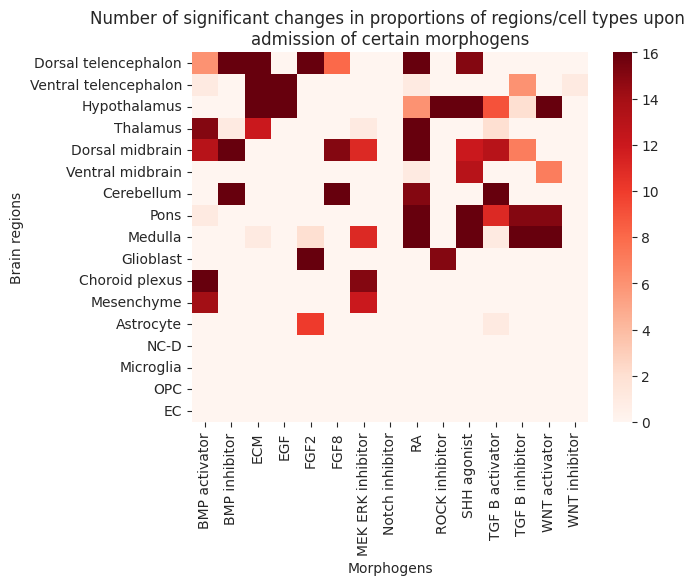

In [68]:
ax=sns.heatmap(df_freq, xticklabels=True, yticklabels=True, cmap='Reds')
ax.set(
    xlabel='Morphogens', 
    ylabel='Brain regions',
    title='Number of significant changes in proportions of regions/cell types upon \nadmission of certain morphogens'
);
plt.savefig(fname=output+'../scCODA_final_num_credible.pdf',format='pdf', bbox_inches="tight")

In [69]:
# function that changes width of bars in barplots
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [116]:
df_plot = df_res.reset_index().melt(id_vars="Region")
df_plot["Morphogen"] = df_plot["Morphogen"].str.replace("_", " ").astype("category")
df_plot["Region"] = df_plot["Region"].replace(rename_regions).astype("category").cat.reorder_categories(reorder_regions)

# remove EC, Microglia and NC-D as they are zero for all mrophogens
df_plot = df_plot.loc[~df_plot["Region"].isin(['EC', 'Microglia', 'NC-D'])]
df_plot["Region"] = df_plot["Region"].cat.remove_unused_categories()

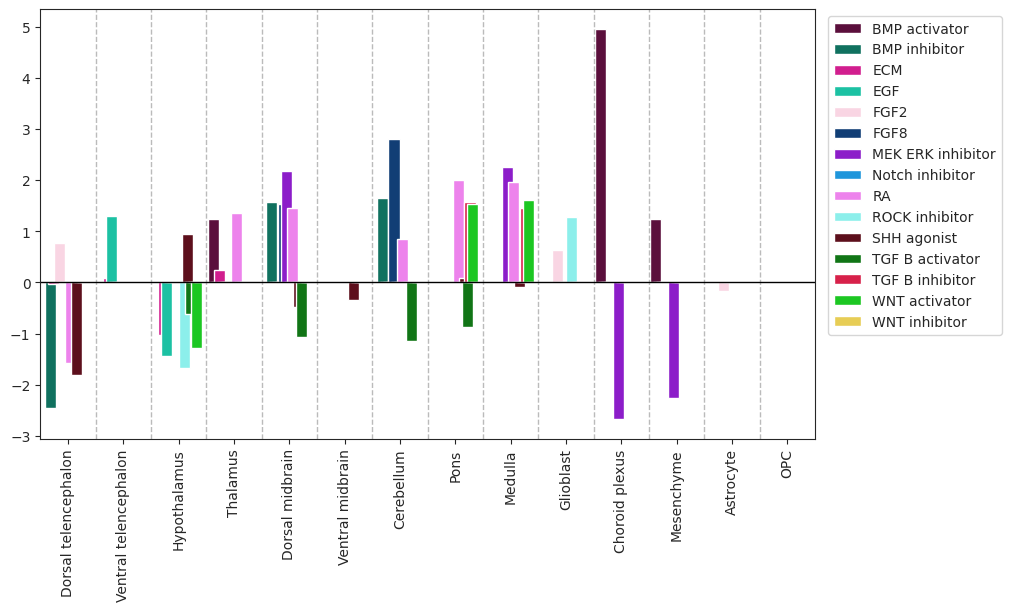

In [117]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.set_style("ticks")

sns.barplot(data=df_plot, 
            x="Region", 
            y='value', 
            hue="Morphogen",
           palette = palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
ax.set(xlabel=None, ylabel=None)
change_width(ax, .2)
for i in range(1,len(df_plot["Region"].unique())):
    plt.axvline(x=i-0.5,linewidth=1, color='#bbbbbb', ls="--")
plt.axhline(y=0,linewidth=1, color='k')
plt.savefig(fname=output+'../scCODA_final_barplot.pdf',format='pdf', bbox_inches="tight")

In [118]:
df = pd.read_csv("240528_glm_a1_l1se_molecule_coefs.tsv", sep="\t")

df["term"] = df["term"].str.replace("_", " ").astype("category")
df["region_coarse"] = df["region_coarse"].str.replace("_", " ").replace(rename_regions).astype("category").cat.reorder_categories(reorder_regions)

In [119]:
# remove EC, Microglia and NC-D as they are zero for all mrophogens
df = df.loc[~df["region_coarse"].isin(['EC', 'Microglia', 'NC-D'])]
df["region_coarse"] = df["region_coarse"].cat.remove_unused_categories()

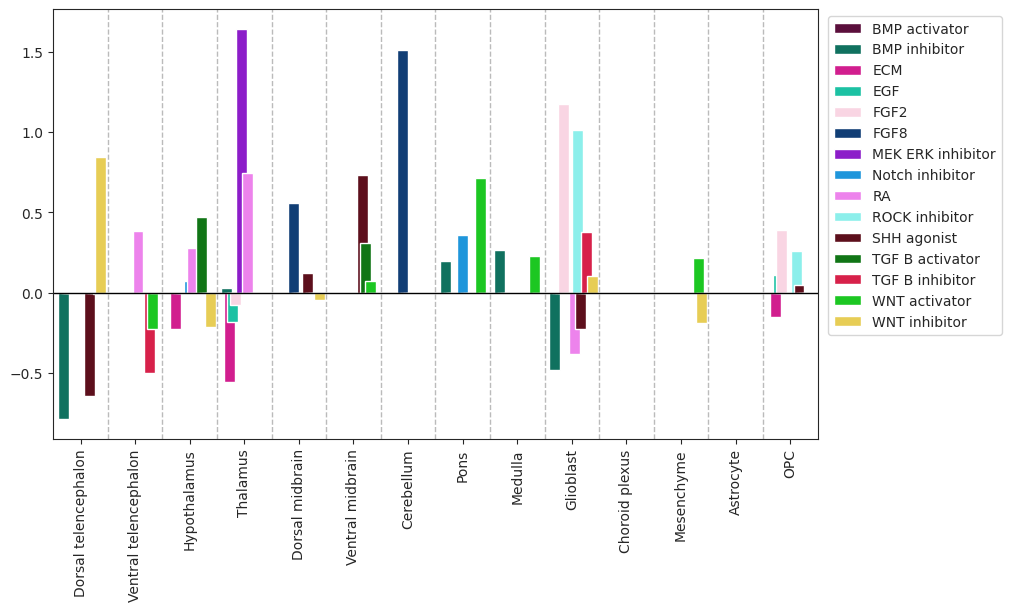

In [120]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.set_style("ticks")

sns.barplot(data=df, 
            x="region_coarse", 
            y='coef', 
            hue="term",
           palette = palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
ax.set(xlabel=None, ylabel=None)
change_width(ax, .2)
for i in range(1,len(df["region_coarse"].unique())):
    plt.axvline(x=i-0.5,linewidth=1, color='#bbbbbb', ls="--")
plt.axhline(y=0,linewidth=1, color='k')
plt.savefig(fname=output+'../lm_final_barplot.pdf',format='pdf', bbox_inches="tight")